### Required dependencies

In [1]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install keras-preprocessing

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


### Imports

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense , BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gensim.downloader as api
from keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.utils.class_weight import compute_class_weight



### Loading Dataset

In [52]:
X_train, y_train = [], []
X_val, y_val = [], []
def read_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                # Split the line into word and label using tab delimiter
                parts = line.strip().split('\t')
                if len(parts) == 2:  # Ensure both word and label are present
                    word, label = parts
                    if file_path.endswith('preprocessed_data.txt'):  # Assuming training data file ends with 'train.txt'
                        X_train.append(word)
                        y_train.append(label)
                    elif file_path.endswith('preprocessed_val_data.txt'):  # Assuming validation data file ends with 'val.txt'
                        X_val.append(word)
                        y_val.append(label)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

# Load training data
read_data('preprocessed_data.txt')

# Load validation data
read_data('preprocessed_val_data.txt')

print(len(X_train) , len(X_val))
print(len(y_train) , len(y_val))


50054 14576
50054 14576


### Loading Weights

In [8]:
glove_vectors = api.load('glove-wiki-gigaword-100')

In [9]:
# from gensim.models.word2vec import Word2Vec

In [10]:
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize
# tokenized_X_train = [word_tokenize(sentence) for sentence in X_train]
# tokenized_X_train[:5] 

# word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)
# word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)


(233842, 1040360)

### Processing Training and Validation data

In [63]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train + X_val)
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_val_indices = tokenizer.texts_to_sequences(X_val)

# Padding sequences
max_sequence_length = max(len(seq) for seq in X_train_indices + X_val_indices)
X_train_padded = pad_sequences(X_train_indices, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_indices, maxlen=max_sequence_length)

label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_val)
y_train_indices = label_encoder.transform(y_train)
y_val_indices = label_encoder.transform(y_val)

# Model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
lstm_units = 256
num_classes = len(np.unique(y_train + y_val))
num_stacked = 3 #controls the depth of the LSTM


# Create embedding matrix from word2vec model
# embedding_matrix = np.zeros((vocab_size, word2vec_model.vector_size))
# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model.raw_vocab:
#         embedding_matrix[i] = word2vec_model[word]




embedding_matrix = np.zeros((vocab_size, glove_vectors.vector_size))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]



### Building Model (Bidirectional LSTM Neural Network)

In [ ]:

# Define LSTM model with additional layers and regularization
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, 
                    weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))
for _ in range(num_stacked - 1):  # Stack additional LSTM layers if specified
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout = 0.2,
                                     recurrent_regularizer=regularizers.l2(0.01) , recurrent_activation= "relu")))
model.add(Bidirectional(LSTM(units=64, return_sequences=True , recurrent_dropout= 0.1)))
model.add(Dense(units=128, activation='tanh',  kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout regularization
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(units=64, activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout regularization
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout regularization
model.add(Dense(units=num_classes, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])


In [64]:
model.summary(show_trainable=True)


Model: "sequential_8"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 embedding_8 (Embedding)     (None, 8, 100)            1662100   N          
                                                                            
 bidirectional_29 (Bidirect  (None, 8, 512)            731136    Y          
 ional)                                                                     
                                                                            
 bidirectional_30 (Bidirect  (None, 8, 512)            1574912   Y          
 ional)                                                                     
                                                                            
 bidirectional_31 (Bidirect  (None, 8, 512)            1574912   Y          
 ional)                                                                     
                                                      

In [66]:
def weighted_categorical_crossentropy(y_true, y_pred):
    if np.unique(y_train + y_val).size != num_classes:  # Check for class imbalance
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train + y_val), y=y_train + y_val)
        return sparse_categorical_crossentropy(y_true, y_pred, class_weight=class_weights)
    else:
        return sparse_categorical_crossentropy(y_true, y_pred)


In [67]:
# Define learning rate schedule using ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True, start_from_epoch=10)

# Compile model with Layer Normalization
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_categorical_crossentropy, metrics=['acc'])


### Training the Model

In [69]:
# Train the model
history = model.fit(X_train_padded, y_train_indices, validation_data=(X_val_padded, y_val_indices),
                    epochs=50, batch_size=128, callbacks=[lr_scheduler, early_stopping],
                    validation_batch_size=32, shuffle=True)


Epoch 1/50
392/392 [==============================] - 110s 240ms/step - loss: 4.3748 - acc: 0.4442 - val_loss: 1.8352 - val_acc: 0.7230 - lr: 0.0010
Epoch 2/50
392/392 [==============================] - 126s 322ms/step - loss: 1.8787 - acc: 0.7314 - val_loss: 6.2495 - val_acc: 0.0150 - lr: 0.0010
Epoch 3/50
392/392 [==============================] - 96s 244ms/step - loss: 1.6733 - acc: 0.7381 - val_loss: 1.7942 - val_acc: 0.7230 - lr: 0.0010
Epoch 4/50
392/392 [==============================] - 91s 233ms/step - loss: 1.5696 - acc: 0.7417 - val_loss: 1.6981 - val_acc: 0.7230 - lr: 0.0010
Epoch 5/50
392/392 [==============================] - 98s 251ms/step - loss: 1.5504 - acc: 0.7414 - val_loss: 1.6839 - val_acc: 0.7417 - lr: 0.0010
Epoch 6/50
392/392 [==============================] - 99s 251ms/step - loss: 1.5376 - acc: 0.7421 - val_loss: 1.5245 - val_acc: 0.7336 - lr: 0.0010
Epoch 7/50
392/392 [==============================] - 95s 242ms/step - loss: 1.5202 - acc: 0.7430 - val_loss: 

### Visualizations of Training process

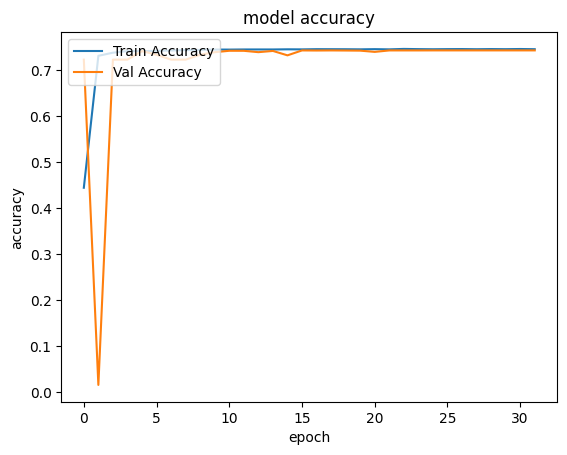

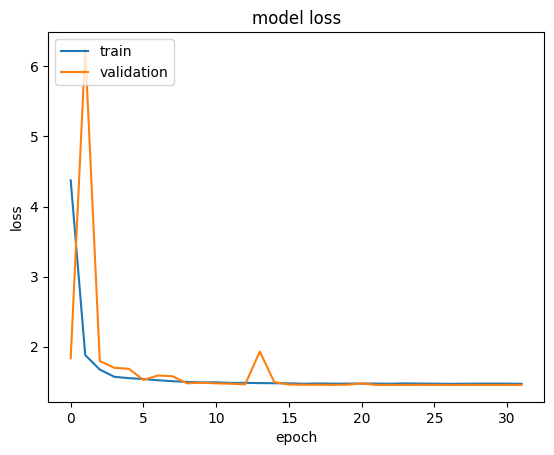

In [72]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation of Model

In [73]:
print("Evaluating model.....")
# Evaluate the model
loss, accuracy = model.evaluate(X_val_padded, y_val_indices)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
print("\nMetrics: ")


y_val_pred_prob = model.predict(X_val_padded)
y_val_pred_classes = np.argmax(y_val_pred_prob, axis=1)

from sklearn.metrics import f1_score, recall_score, precision_score

# Step 3: Compute F1-score, recall, and precision
f1 = f1_score(y_val_indices, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_indices, y_val_pred_classes, average='weighted')
precision = precision_score(y_val_indices, y_val_pred_classes, average='weighted')

print(f'\nValidation F1 Score: {f1}')
print(f'Validation Recall: {recall}')
print(f'Validation Precision: {precision}')

Evaluating model.....
456/456 [==============================] - 10s 21ms/step - loss: 1.4537 - acc: 0.7431
Validation Loss: 1.453677773475647, Validation Accuracy: 0.743139386177063

Metrics: 
456/456 [==============================] - 15s 27ms/step

Validation F1 Score: 0.6390215057234017
Validation Recall: 0.743139407244786
Validation Precision: 0.5607220957528464


c:\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing Model

In [74]:
X_test, y_test = [], []

def read_test(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                # Split the line into word and label using tab delimiter
                parts = line.strip()
                X_test.append(parts)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

read_test('test_set.txt')

print(len(X_test))


113607


In [76]:
# Tokenize and pad the test data
# X_test = ['تعرف','صبية','فرنسي','قالتلي','أنت','مسلم','قلتل','أي']

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_indices, maxlen=max_sequence_length)
len(X_test_padded)
# Predict the test data
print("Predicting.....")
predictions = model.predict(X_test_padded)
print("Prediciton Completed!!")
# If your model's output is probabilities and you need class labels, use argmax
predicted_classes = np.argmax(predictions, axis=1)
y_test_pred_labels = label_encoder.inverse_transform(predicted_classes)
# Save predictions to a text file
output_file = 'model_pred.txt'
with open(output_file, 'w',encoding='utf-8') as f:
    for i, prediction in enumerate(y_test_pred_labels):
        f.write(f"{X_test[i]}       {prediction}\n")
        # print(f"{X_test[i]} {prediction}\n")
print("File Saved Successfully!!")



Predicting.....
3551/3551 [==============================] - 92s 26ms/step
Prediciton Completed!!
File Saved Successfully!!
